## Offline RL
This lab is adapted from https://sites.google.com/view/offlinerltutorial-neurips2020/home

We will implement:
*   q-learning (as baseline)
*   Fitted Q-iteration, which can be considered a naive approach to offline RL
*   Conservative fitted Q-iteration, which aims to correct the distributional shift

We will be working on the simple maze environment, defined with a string:

SOOOOOO#

O##O###O

OO#OO##O

O#RO#OO#


*   O is an empty field, where the agent can walk in
*   R is the field with reward
*   \# is a wall
*   S is the starting position

Below we have several utilities (just execute those cells). 

In [1]:
#@title Imports
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Polygon
from IPython.display import clear_output
import torch
%matplotlib inline  

In [2]:
#@title Environment Code
import sys

EMPTY = 110
WALL = 111
START = 112
REWARD = 113
OUT_OF_BOUNDS = 114
LAVA = 118

TILES = {EMPTY, WALL, START, REWARD, LAVA}

STR_MAP = {
    'O': EMPTY,
    '#': WALL,
    'S': START,
    'R': REWARD,
    'L': LAVA
}

RENDER_DICT = {v:k for k, v in STR_MAP.items()}
RENDER_DICT[EMPTY] = ' '
RENDER_DICT[START] = ' '


def spec_from_string(s, valmap=STR_MAP):
    if s.endswith('\\'):
        s = s[:-1]
    rows = s.split('\\')
    rowlens = np.array([len(row) for row in rows])
    assert np.all(rowlens == rowlens[0])
    w, h = len(rows[0]), len(rows)

    gs = GridSpec(w, h)
    for i in range(h):
        for j in range(w):
            gs[j,i] = valmap[rows[i][j]]
    return gs


def spec_from_sparse_locations(w, h, tile_to_locs):
    """

    Example usage:
    >> spec_from_sparse_locations(10, 10, {START: [(0,0)], REWARD: [(7,8), (8,8)]})

    """
    gs = GridSpec(w, h)
    for tile_type in tile_to_locs:
        locs = np.array(tile_to_locs[tile_type])
        for i in range(locs.shape[0]):
            gs[tuple(locs[i])] = tile_type
    return gs


def local_spec(map, xpnt):
    """
    >>> local_spec("yOy\\\\Oxy", xpnt=(5,5))
    array([[4, 4],
           [6, 4],
           [6, 5]])
    """
    Y = 0; X=1; O=2
    valmap={
        'y': Y,
        'x': X,
        'O': O
    }
    gs = spec_from_string(map, valmap=valmap)
    ys = gs.find(Y)
    x = gs.find(X)
    result = ys-x + np.array(xpnt)
    return result


class GridSpec(object):
    def __init__(self, w, h):
        self.__data = np.zeros((w, h), dtype=np.int32)
        self.__w = w
        self.__h = h

    def __setitem__(self, key, val):
        self.__data[key] = val

    def __getitem__(self, key):
        if self.out_of_bounds(key):
            raise NotImplementedError("Out of bounds:"+str(key))
        return self.__data[tuple(key)]

    def out_of_bounds(self, wh):
        """ Return true if x, y is out of bounds """
        w, h = wh
        if w<0 or w>=self.__w:
            return True
        if h < 0 or h >= self.__h:
            return True
        return False

    def get_neighbors(self, k, xy=False):
        """ Return values of up, down, left, and right tiles """
        if not xy:
            k = self.idx_to_xy(k)
        offsets = [np.array([0,-1]), np.array([0,1]),
                   np.array([-1,0]), np.array([1,0])]
        neighbors = \
            [self[k+offset] if (not self.out_of_bounds(k+offset)) else OUT_OF_BOUNDS for offset in offsets ]
        return neighbors

    def get_value(self, k, xy=False):
        """ Return values of up, down, left, and right tiles """
        if not xy:
            k = self.idx_to_xy(k)
        return self[k]

    def find(self, value):
        return np.array(np.where(self.spec == value)).T

    @property
    def spec(self):
        return self.__data

    @property
    def width(self):
        return self.__w

    def __len__(self):
        return self.__w*self.__h

    @property
    def height(self):
        return self.__h

    def idx_to_xy(self, idx):
        if hasattr(idx, '__len__'):  # array
            x = idx % self.__w
            y = np.floor(idx/self.__w).astype(np.int32)
            xy = np.c_[x,y]
            return xy
        else:
            return np.array([ idx % self.__w, int(np.floor(idx/self.__w))])

    def xy_to_idx(self, key):
        shape = np.array(key).shape
        if len(shape) == 1:
            return key[0] + key[1]*self.__w
        elif len(shape) == 2:
            return key[:,0] + key[:,1]*self.__w
        else:
            raise NotImplementedError()

    def __hash__(self):
        data = (self.__w, self.__h) + tuple(self.__data.reshape([-1]).tolist())
        return hash(data)
 

ACT_NOOP = 0
ACT_UP = 1
ACT_DOWN = 2
ACT_LEFT = 3
ACT_RIGHT = 4
ACT_DICT = {
    ACT_NOOP: [0,0],
    ACT_UP: [0, -1],
    ACT_LEFT: [-1, 0],
    ACT_RIGHT: [+1, 0],
    ACT_DOWN: [0, +1]
}
ACT_TO_STR = {
    ACT_NOOP: 'NOOP',
    ACT_UP: 'UP',
    ACT_LEFT: 'LEFT',
    ACT_RIGHT: 'RIGHT',
    ACT_DOWN: 'DOWN'
}

class TransitionModel(object):
    def __init__(self, gridspec, eps=0.2):
        self.gs = gridspec
        self.eps = eps

    def get_aprobs(self, s, a):
        legal_moves = self.__get_legal_moves(s)
        p = np.zeros(len(ACT_DICT))
        p[legal_moves] = self.eps / (len(legal_moves))
        if a in legal_moves:
            p[a] += 1.0-self.eps
        else:
            #p = np.array([1.0,0,0,0,0])  # NOOP
            p[ACT_NOOP] += 1.0-self.eps
        return p

    def __get_legal_moves(self, s):
        xy = np.array(self.gs.idx_to_xy(s))
        moves = [move for move in ACT_DICT if not self.gs.out_of_bounds(xy+ACT_DICT[move])
                                             and self.gs[xy+ACT_DICT[move]] != WALL]
        return moves

      
OBS_ONEHOT = 'onehot'
OBS_RANDOM = 'random'
OBS_SMOOTH = 'smooth'


class GridEnv(object):
    def __init__(self, gridspec, 
                 teps=0.0,
                 observation_type=OBS_ONEHOT,
                 dim_obs=8):
        super(GridEnv, self).__init__()
        self.num_states = len(gridspec)
        self.num_actions = 5
        self.obs_type = observation_type
        self.gs = gridspec
        self.model = TransitionModel(gridspec, eps=teps)
        self._transition_matrix = None
        self._transition_matrix = self.transition_matrix()

        if self.obs_type == OBS_RANDOM:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
        elif self.obs_type == OBS_SMOOTH:
          self.dim_obs = dim_obs
          self.obs_matrix = np.random.randn(self.num_states, self.dim_obs)
          trans_matrix = np.sum(self._transition_matrix, axis=1) / self.num_actions
          for k in range(10):
            cur_obs_mat = self.obs_matrix[:,:]
            for state in range(self.num_states):
                new_obs = trans_matrix[state].dot(cur_obs_mat)
                self.obs_matrix[state] = new_obs
        else:
          self.dim_obs = self.gs.width+self.gs.height

    def observation(self, s):
        if self.obs_type == OBS_ONEHOT:
          xy_vec = np.zeros(self.gs.width+self.gs.height)
          xy = self.gs.idx_to_xy(s)
          xy_vec[xy[0]] = 1.0
          xy_vec[xy[1]+self.gs.width] = 1.0
          return xy_vec
        elif self.obs_type == OBS_RANDOM or self.obs_type == OBS_SMOOTH:
          return self.obs_matrix[s]
        else:
          raise ValueError("Invalid obs type %s" % self.obs_type)
        
    def reward(self, s, a, ns):
        """ 
        Returns the reward (float)
        """
        tile_type = self.gs[self.gs.idx_to_xy(s)]
        if tile_type == REWARD:
          return 1
        elif tile_type == LAVA:
          return -1
        else:
          return 0

    def transitions(self, s, a):
        """
        Returns a dictionary of next_state (int) -> prob (float)
        """
        tile_type = self.gs[self.gs.idx_to_xy(s)]
        #if tile_type == LAVA: # Lava gets you stuck
        #    return {s: 1.0}
        if tile_type == WALL:
          return {s: 1.0}

        aprobs = self.model.get_aprobs(s, a)
        t_dict = {}
        for sa in range(5):
            if aprobs[sa] > 0:
                next_s = self.gs.idx_to_xy(s) + ACT_DICT[sa]
                next_s_idx = self.gs.xy_to_idx(next_s)
                t_dict[next_s_idx] = t_dict.get(next_s_idx, 0.0) + aprobs[sa]
        return t_dict
      
    def initial_state_distribution(self):
        start_idxs = np.array(np.where(self.gs.spec == START)).T
        num_starts = start_idxs.shape[0]
        initial_distribution = {}
        for i in range(num_starts):
          initial_distribution[self.gs.xy_to_idx(start_idxs[i])] = 1.0/num_starts 
        return initial_distribution

    def step_stateless(self, s, a, verbose=False):
        probs = self.transitions(s, a).items()
        ns_idx = np.random.choice(range(len(probs)), p=[p[1] for p in probs])
        ns = probs[ns_idx][0]
        rew = self.reward(s, a, ns)
        return ns, rew

    def step(self, a, verbose=False):
        ns, r = self.step_stateless(self.__state, a, verbose=verbose)
        self.__state = ns
        return ns, r, False, {}

    def reset(self):
        init_distr = self.initial_state_distribution().items()
        start_idx = np.random.choice(len(init_distr), p=[p[1] for p in init_distr])
        self.__state = init_distr[start_idx][0]
        self._timestep = 0
        return start_idx

    def render(self, close=False, ostream=sys.stdout):
        if close:
            return

        state = self.__state
        ostream.write('-'*(self.gs.width+2)+'\n')
        for h in range(self.gs.height):
            ostream.write('|')
            for w in range(self.gs.width):
                if self.gs.xy_to_idx((w,h)) == state:
                    ostream.write('*')
                else:
                    val = self.gs[w, h]
                    ostream.write(RENDER_DICT[val])
            ostream.write('|\n')
        ostream.write('-' * (self.gs.width + 2)+'\n')
        
    def transition_matrix(self):
        if self._transition_matrix is None:
          transition_matrix = np.zeros((self.num_states, self.num_actions, self.num_states))
          for s in range(self.num_states):
            for a in range(self.num_actions):
              for ns, prob in self.transitions(s, a).items():
                transition_matrix[s,a,ns] = prob
          self._transition_matrix = transition_matrix
        return self._transition_matrix

In [3]:
#@title Plotting Code
PLT_NOOP = np.array([[-0.1,0.1], [-0.1,-0.1], [0.1,-0.1], [0.1,0.1]])
PLT_UP = np.array([[0,0], [0.5,0.5], [-0.5,0.5]])
PLT_LEFT = np.array([[0,0], [-0.5,0.5], [-0.5,-0.5]])
PLT_RIGHT = np.array([[0,0], [0.5,0.5], [0.5,-0.5]])
PLT_DOWN = np.array([[0,0], [0.5,-0.5], [-0.5,-0.5]])

TXT_OFFSET_VAL = 0.3
TXT_CENTERING = np.array([-0.08, -0.05])
TXT_NOOP = np.array([0.0,0])+TXT_CENTERING
TXT_UP = np.array([0,TXT_OFFSET_VAL])+TXT_CENTERING
TXT_LEFT = np.array([-TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_RIGHT = np.array([TXT_OFFSET_VAL,0])+TXT_CENTERING
TXT_DOWN = np.array([0,-TXT_OFFSET_VAL])+TXT_CENTERING

ACT_OFFSETS = [
    [PLT_NOOP, TXT_NOOP],
    [PLT_UP, TXT_UP],
    [PLT_DOWN, TXT_DOWN],
    [PLT_LEFT, TXT_LEFT],
    [PLT_RIGHT, TXT_RIGHT]
]

PLOT_CMAP = cm.RdYlBu

def plot_sa_values(env, q_values, text_values=True, 
                   invert_y=True, update=False,
                   title=None):
  w = env.gs.width
  h = env.gs.height
  
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = q_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = env.gs.xy_to_idx((x, y))
      if invert_y:
          y = h-y-1
      xy = np.array([x, y])
      xy3 = np.expand_dims(xy, axis=0)

      for a in range(4, -1, -1):
          val = normalized_values[state_idx,a]
          og_val = q_values[state_idx,a]
          patch_offset, txt_offset = ACT_OFFSETS[a]
          if text_values:
              xy_text = xy+txt_offset
              ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
          color = PLOT_CMAP(val)
          ax.add_patch(Polygon(xy3+patch_offset, True,
                                     color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()
  if title:
    plt.title(title)
  plt.show()

def plot_s_values(env, v_values, text_values=True, 
                  invert_y=True, update=False,
                  title=None):
  w = env.gs.width
  h = env.gs.height
  if update:
    clear_output(wait=True)
  plt.figure(figsize=(2*w, 2*h))
  ax = plt.gca()
  normalized_values = v_values
  normalized_values = normalized_values - np.min(normalized_values)
  normalized_values = normalized_values/np.max(normalized_values)
  for x, y in itertools.product(range(w), range(h)):
      state_idx = env.gs.xy_to_idx((x, y))
      if invert_y:
          y = h-y-1
      xy = np.array([x, y])

      val = normalized_values[state_idx]
      og_val = v_values[state_idx]
      if text_values:
          xy_text = xy
          ax.text(xy_text[0], xy_text[1], '%.2f'%og_val, size='small')
      color = PLOT_CMAP(val)
      ax.add_patch(Rectangle(xy-0.5, 1, 1, color=color))
  ax.set_xticks(np.arange(-1, w+1, 1))
  ax.set_yticks(np.arange(-1, h+1, 1))
  plt.grid()  
  if title:
    plt.title(title)
  plt.show()
  

In [4]:
#@title Utility Functions

def compute_policy_deterministic(q_values, eps_greedy=0.0):
  policy_probs = np.zeros_like(q_values)
  policy_probs[np.arange(policy_probs.shape[0]), np.argmax(q_values, axis=1)] = 1.0 - eps_greedy
  policy_probs += eps_greedy / (policy_probs.shape[1])
  return policy_probs

def compute_visitation(env, policy, discount=1.0, T=50):
  dS = env.num_states
  dA = env.num_actions
  state_visitation = np.zeros((dS, 1))
  for (state, prob) in env.initial_state_distribution().items():
    state_visitation[state] = prob
  t_matrix = env.transition_matrix()  # S x A x S
  sa_visit_t = np.zeros((dS, dA, T))

  norm_factor = 0.0
  for i in range(T):
    sa_visit = state_visitation * policy
    cur_discount = (discount ** i)
    sa_visit_t[:, :, i] = cur_discount * sa_visit
    # norm_factor += cur_discount
    norm_factor = 1
    # sum-out (SA)S
    new_state_visitation = np.einsum('ij,ijk->k', sa_visit, t_matrix)
    state_visitation = np.expand_dims(new_state_visitation, axis=1)
  return np.sum(sa_visit_t, axis=2) / norm_factor

def get_tensors(list_of_tensors, list_of_indices):
  s, a, ns, r = [], [], [], []
  for idx in list_of_indices:
    s.append(list_of_tensors[idx][0])
    a.append(list_of_tensors[idx][1])
    r.append(list_of_tensors[idx][2])
    ns.append(list_of_tensors[idx][3])
  s = np.array(s)
  a = np.array(a)
  ns = np.array(ns)
  r = np.array(r)
  return s, a, ns, r

In [5]:
#@title Neural Network Code

def stack_observations(env):
    obs = []
    for s in range(env.num_states):
        obs.append(env.observation(s))
    return np.stack(obs)

class FCNetwork(torch.nn.Module):
  def __init__(self, env, layers=[20,20]):
    super(FCNetwork, self).__init__()
    self.all_observations = torch.tensor(stack_observations(env), dtype=torch.float32)
    dim_input = env.dim_obs
    dim_output = env.num_actions
    net_layers = []

    dim = dim_input
    for i, layer_size in enumerate(layers):
      net_layers.append(torch.nn.Linear(dim, layer_size))
      net_layers.append(torch.nn.ReLU())
      dim = layer_size
    net_layers.append(torch.nn.Linear(dim, dim_output))
    self.layers = net_layers
    self.network = torch.nn.Sequential(*net_layers)

  def forward(self, states):
    observations = torch.index_select(self.all_observations, 0, states) 
    return self.network(observations)
  

def one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot
  

class TabularNetwork(torch.nn.Module):
  def __init__(self, env):
    super(TabularNetwork, self).__init__()
    self.num_states = env.num_states
    self.network = torch.nn.Sequential(
        torch.nn.Linear(self.num_states, env.num_actions)
    )

  def forward(self, states):
    onehot = one_hot(states, self.num_states)
    return self.network(onehot)

##Tabular q-learning


We will start by training a baseline: tabular q-learning. Remember that the environment is stochastic. 

**Exercise** Fill the gaps in the code below:

In [6]:
def q_backup_sparse(env, q_values, discount=0.99):
  #This functions performs q-update for the whole action-space.
  dS = env.num_states
  dA = env.num_actions
    
  new_q_values = np.zeros_like(q_values)
  value = np.max(q_values, axis=1)
  for s in range(dS):
    for a in range(dA):
      new_q_value = 0
      for ns, prob in env.transitions(s, a).items():
        #ns is a new state possible to obtain by applying action a to the state s
        #prob it the probability of transition (s, a) -> ns
        #Here we need to apply Bellman equation (with the expectance over transition probabilities)
        reward = env.reward(s,a,ns)
        new_q_value += prob * (reward + discount*value[ns])
      new_q_values[s,a] = new_q_value
  return new_q_values

def q_iteration(env, num_itrs=100, render=False, **kwargs):
  """
  Run tabular Q-iteration
  
  Args:
    env: A GridEnv object
    num_itrs (int): Number of iterations to run
    render (bool): If True, will plot q-values after each iteration
  """
  q_values = np.zeros((env.num_states, env.num_actions))
  for i in range(num_itrs):
    q_values = q_backup_sparse(env, q_values, **kwargs)
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values')
  return q_values

**Experiment** Run the following code to find the optimal q-values and visualize the behvaior of the optimal policy

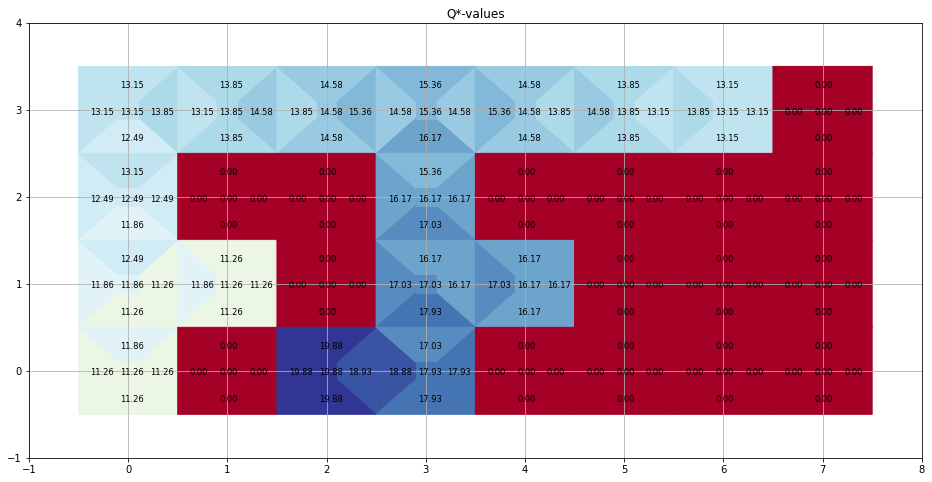

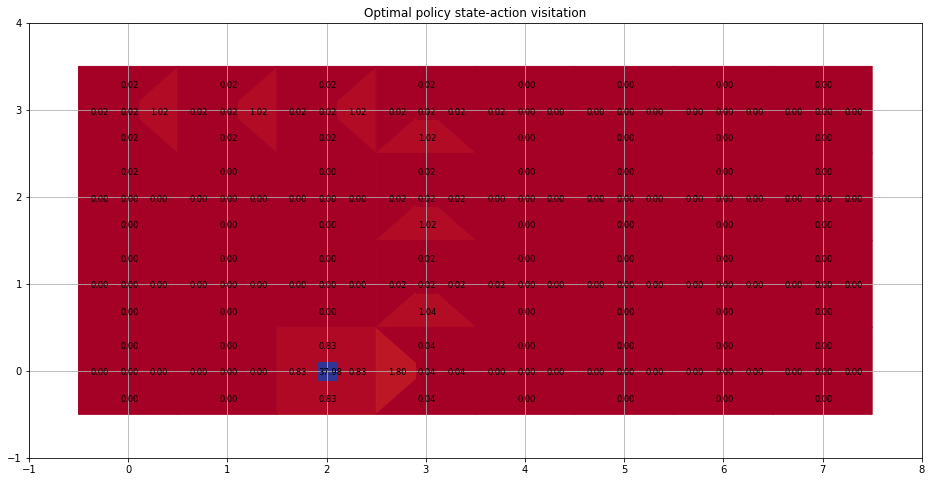

In [7]:
maze = spec_from_string("SOOOOOO#\\"+
                        "O##O###O\\"+
                        "OO#OO##O\\"+
                        "O#RO#OO#\\"
                       )

env = GridEnv(maze, observation_type='smooth', dim_obs=8)
optimal_qvalues = q_iteration(env, num_itrs=100, discount=0.95, render=False)

plot_sa_values(env, optimal_qvalues, title='Q*-values')

policy = compute_policy_deterministic(optimal_qvalues, eps_greedy=0.1)
sa_visitations = compute_visitation(env, policy)
plot_sa_values(env, sa_visitations, title='Optimal policy state-action visitation')

#Fitted Q-iteration

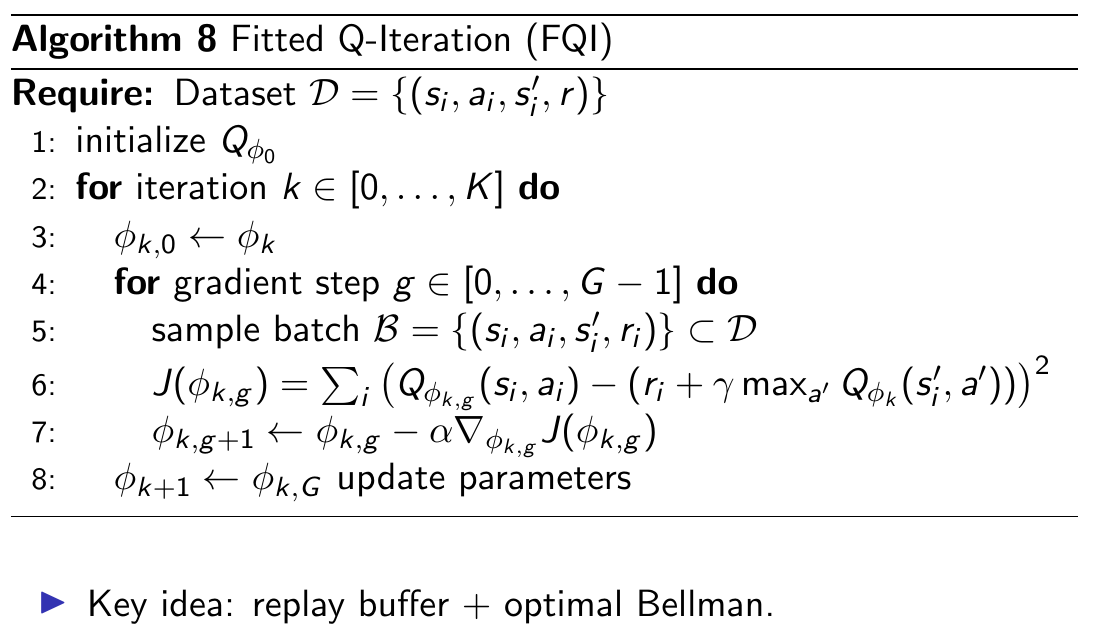

Fitted Q-Iteration is an algorithm very similar to Q-learning with the biggest difference being the fact that we have a fixed dataset of transitions, and we cannot generate any new samples during the training. 

**Exercise** Fill the gaps in the algorithm.

In [13]:
def q_backup_sparse_sampled(env, q_values, s, a, ns, r, discount=0.99):
  #Here is an additional function to perform q_backup for sampled transition
  q_values_ns = q_values[ns, :]
  #For each state-action in q_values choose the maximum along actions dimension (axis=-1)
  values = np.max(q_values_ns, axis=-1)
  #Update the target values according to Bellman equation, i.e.
  target_value = r + discount * values
  return target_value

def project_qvalues_sampled(env, s, a, target_values, network, optimizer, num_steps=50, weights=None):
    # Train on sampled transitions
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()
    loss = torch.mean((pred_qvalues - target_qvalues)**2)
    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()

  
def fitted_q_iteration(env, 
                       network,
                       num_itrs=100, 
                       project_steps=50,
                       render=False,
                       training_dataset=None,
                       **kwargs):
  """
  Runs Fitted Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    render (bool): If True, will plot q-values after each iteration.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  
  q_values = np.zeros((dS, dA))
  for i in range(num_itrs):
    for j in range(project_steps):
      #Sample a batch of transitions from the training_dataset
      #First we will sample indices of transitions, we want to use.
      #Here sample a batch of size 128 
      training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
      s, a, ns, r = get_tensors(training_dataset, training_idx)
      #Apply q_backup_sparse_sampled with the appropriate arguments (i.e. fill the arguments + send kwargs)
      target_values = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
      intermed_values = project_qvalues_sampled(
          env, s, a, target_values, network, optimizer, weights=None,
      )
      if j == project_steps - 1:
        q_values = intermed_values
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  return q_values

Here we will generate a fixed size dataset for later training. You can choose what how we compose the dataset and its size.

In [9]:
# # @title Input Parameters

dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  100#@param {type: "integer"}

In [10]:
#@title Dataset generation

if dataset_composition == 'optimal':
  """Distribution of the optimal policy (+ some noise)"""
  weights = sa_visitations
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random':
  """A random disribution over states and actions""" 
  weights = np.random.uniform(size=env.num_states * env.num_actions)
  weights = np.reshape(weights, (env.num_states, env.num_actions))
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random+optimal':
  """Mixture of random and optimal policies"""
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
  weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
  weights = (weights_rand + weights)/2.0
elif dataset_composition == 'mixed':
  """Mixture of policies corresponding to random Q-values"""
  num_policies_mix = 4
  weights = np.zeros_like(sa_visitations)
  for idx in range(num_policies_mix):
    rand_q_vals_idx = np.random.uniform(low=0.0, high=10.0, size=(env.num_states, env.num_actions))
    policy_idx = compute_policy_deterministic(rand_q_vals_idx, eps_greedy=0.1)
    sa_visitations_idx = compute_visitation(env, policy_idx)
    weights = weights + sa_visitations_idx
  weights = weights / np.sum(weights)

weights_flatten = np.reshape(weights, -1)
weights_flatten = weights_flatten/ np.sum(weights_flatten)
dataset = np.random.choice(
    np.arange(env.num_states * env.num_actions),
    size=dataset_size, replace=True, p=weights_flatten
)
training_sa_pairs = [(int(val//env.num_actions), val % env.num_actions) for val in dataset]

# Now sample (s', r) values for training as well
training_dataset = []
training_data_dist = np.zeros((env.num_states, env.num_actions))
for idx in range(len(training_sa_pairs)):
  s, a = training_sa_pairs[idx]
  prob_s_prime = env._transition_matrix[s, a]
  s_prime = np.random.choice(np.arange(env.num_states), p=prob_s_prime)
  r = env.reward(s, a, s_prime)
  training_dataset.append((s, a, r, s_prime))
  training_data_dist[s, a] += 1.0

Let's see the structure of the dataset:

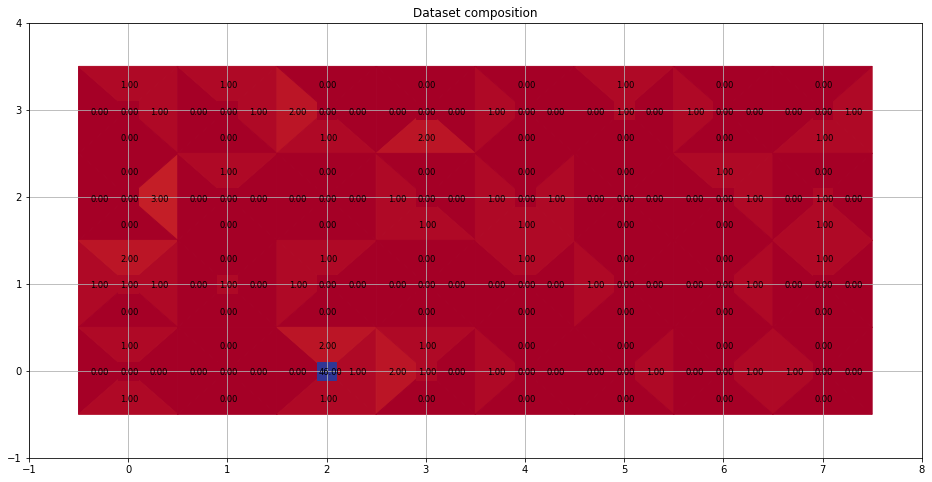

In [11]:
plot_sa_values(env, training_data_dist, title='Dataset composition')

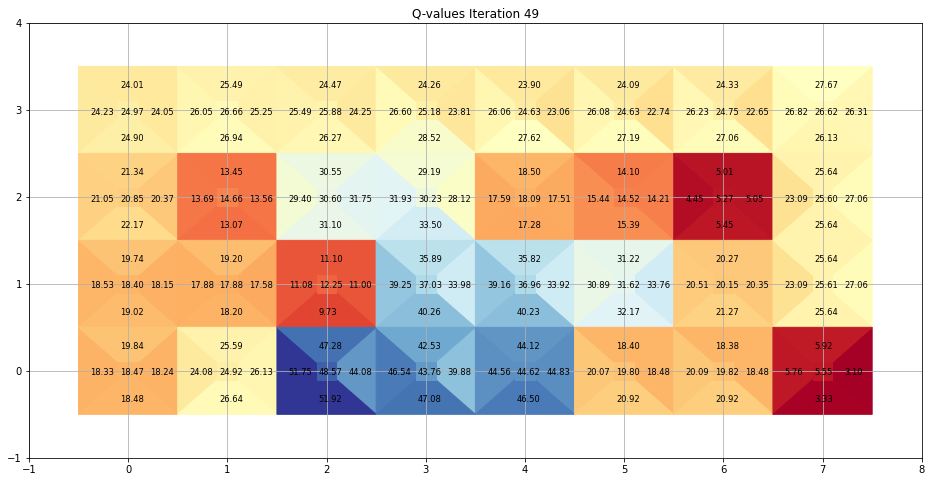

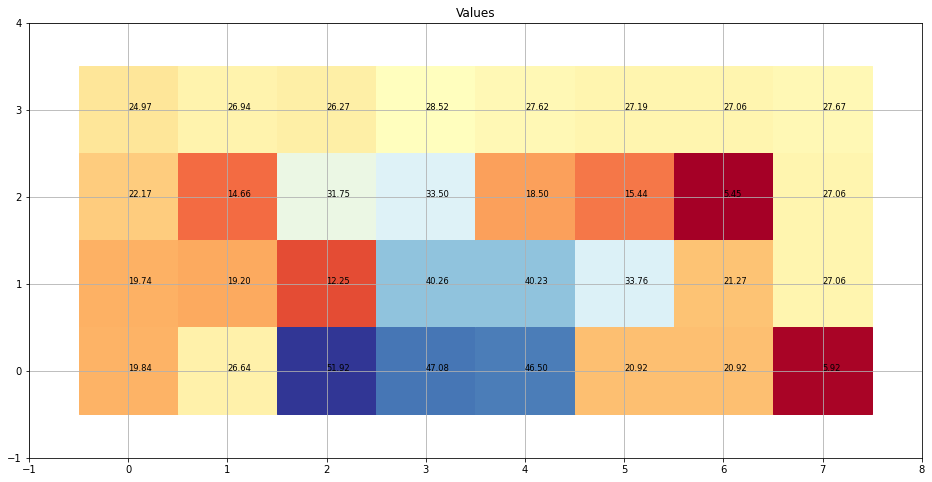

In [14]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])

# Run Q-iteration
q_values = fitted_q_iteration(env, network,
                              num_itrs=50, discount=0.95, 
                              render=True,
                              training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

Lets see how errorous is our trained q-value. We define the error as the sum of absolute values of differences between our q-value and the optimal q-value.

In [15]:
print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

Total Error: 2777.7384738418173


**Excercise** Analyze how the total error depends on the size of the dataset and the structure of the dataset (run several experiments and prepare a simple plot for the dataset size).

In [20]:
# # @title Input Parameters

dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  500#@param {type: "integer"}

In [21]:
#@title Dataset generation

if dataset_composition == 'optimal':
  """Distribution of the optimal policy (+ some noise)"""
  weights = sa_visitations
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random':
  """A random disribution over states and actions""" 
  weights = np.random.uniform(size=env.num_states * env.num_actions)
  weights = np.reshape(weights, (env.num_states, env.num_actions))
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random+optimal':
  """Mixture of random and optimal policies"""
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
  weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
  weights = (weights_rand + weights)/2.0
elif dataset_composition == 'mixed':
  """Mixture of policies corresponding to random Q-values"""
  num_policies_mix = 4
  weights = np.zeros_like(sa_visitations)
  for idx in range(num_policies_mix):
    rand_q_vals_idx = np.random.uniform(low=0.0, high=10.0, size=(env.num_states, env.num_actions))
    policy_idx = compute_policy_deterministic(rand_q_vals_idx, eps_greedy=0.1)
    sa_visitations_idx = compute_visitation(env, policy_idx)
    weights = weights + sa_visitations_idx
  weights = weights / np.sum(weights)

weights_flatten = np.reshape(weights, -1)
weights_flatten = weights_flatten/ np.sum(weights_flatten)
dataset = np.random.choice(
    np.arange(env.num_states * env.num_actions),
    size=dataset_size, replace=True, p=weights_flatten
)
training_sa_pairs = [(int(val//env.num_actions), val % env.num_actions) for val in dataset]

# Now sample (s', r) values for training as well
training_dataset = []
training_data_dist = np.zeros((env.num_states, env.num_actions))
for idx in range(len(training_sa_pairs)):
  s, a = training_sa_pairs[idx]
  prob_s_prime = env._transition_matrix[s, a]
  s_prime = np.random.choice(np.arange(env.num_states), p=prob_s_prime)
  r = env.reward(s, a, s_prime)
  training_dataset.append((s, a, r, s_prime))
  training_data_dist[s, a] += 1.0

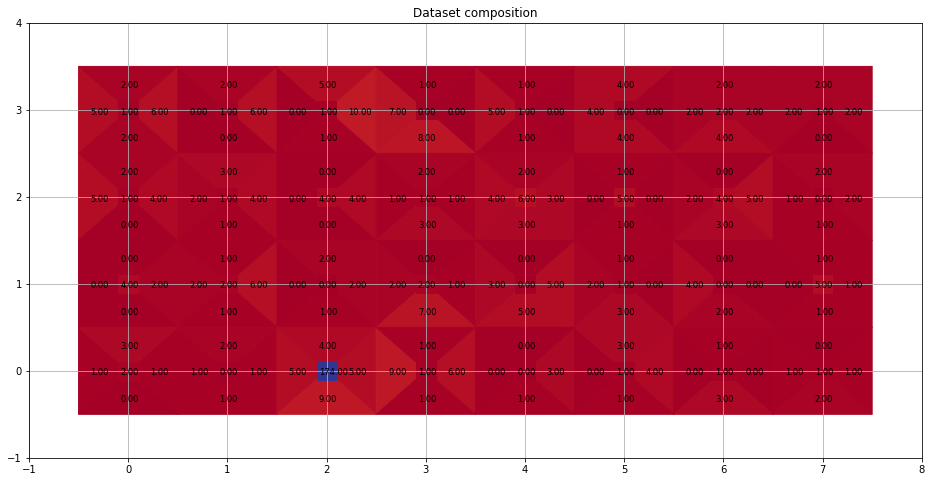

In [22]:
plot_sa_values(env, training_data_dist, title='Dataset composition')

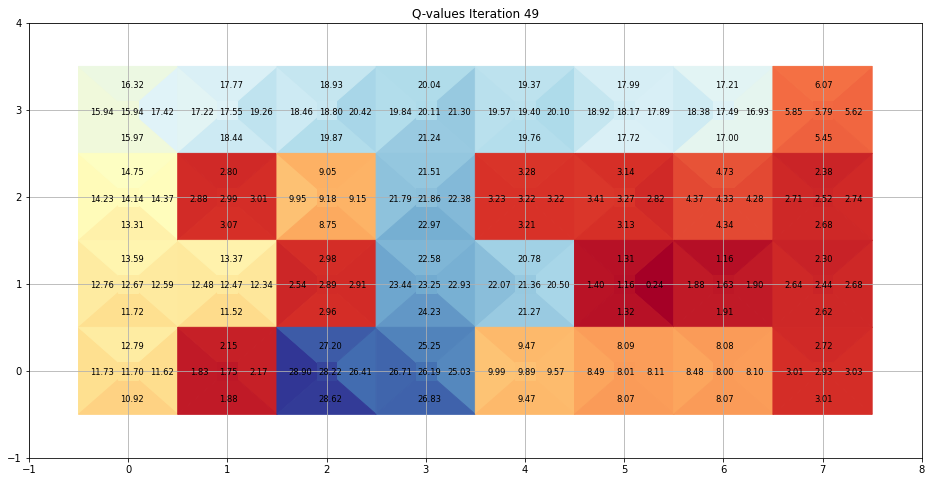

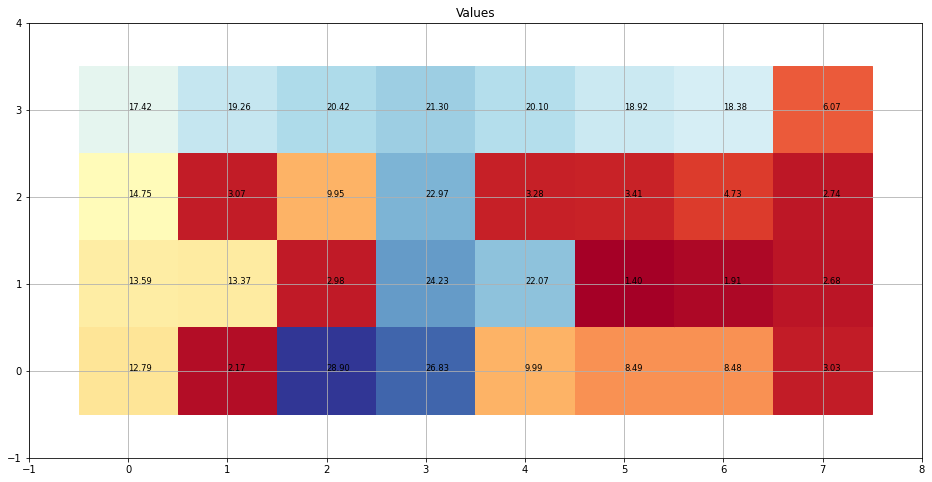

In [23]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])

# Run Q-iteration
q_values = fitted_q_iteration(env, network,
                              num_itrs=50, discount=0.95, 
                              render=True,
                              training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

In [24]:
# # @title Input Parameters

dataset_composition = 'optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  100#@param {type: "integer"}

In [25]:
#@title Dataset generation

if dataset_composition == 'optimal':
  """Distribution of the optimal policy (+ some noise)"""
  weights = sa_visitations
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random':
  """A random disribution over states and actions""" 
  weights = np.random.uniform(size=env.num_states * env.num_actions)
  weights = np.reshape(weights, (env.num_states, env.num_actions))
  weights = weights/ np.sum(weights)
elif dataset_composition == 'random+optimal':
  """Mixture of random and optimal policies"""
  weights = sa_visitations / np.sum(sa_visitations)
  weights_rand = np.random.uniform(size=env.num_states * env.num_actions)
  weights_rand = np.reshape(weights_rand, (env.num_states, env.num_actions)) / np.sum(weights_rand)
  weights = (weights_rand + weights)/2.0
elif dataset_composition == 'mixed':
  """Mixture of policies corresponding to random Q-values"""
  num_policies_mix = 4
  weights = np.zeros_like(sa_visitations)
  for idx in range(num_policies_mix):
    rand_q_vals_idx = np.random.uniform(low=0.0, high=10.0, size=(env.num_states, env.num_actions))
    policy_idx = compute_policy_deterministic(rand_q_vals_idx, eps_greedy=0.1)
    sa_visitations_idx = compute_visitation(env, policy_idx)
    weights = weights + sa_visitations_idx
  weights = weights / np.sum(weights)

weights_flatten = np.reshape(weights, -1)
weights_flatten = weights_flatten/ np.sum(weights_flatten)
dataset = np.random.choice(
    np.arange(env.num_states * env.num_actions),
    size=dataset_size, replace=True, p=weights_flatten
)
training_sa_pairs = [(int(val//env.num_actions), val % env.num_actions) for val in dataset]

# Now sample (s', r) values for training as well
training_dataset = []
training_data_dist = np.zeros((env.num_states, env.num_actions))
for idx in range(len(training_sa_pairs)):
  s, a = training_sa_pairs[idx]
  prob_s_prime = env._transition_matrix[s, a]
  s_prime = np.random.choice(np.arange(env.num_states), p=prob_s_prime)
  r = env.reward(s, a, s_prime)
  training_dataset.append((s, a, r, s_prime))
  training_data_dist[s, a] += 1.0

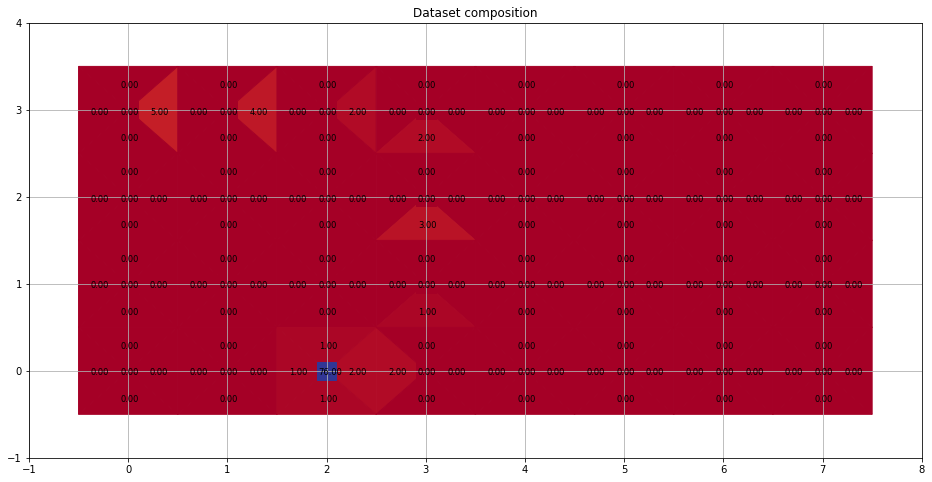

In [26]:
plot_sa_values(env, training_data_dist, title='Dataset composition')

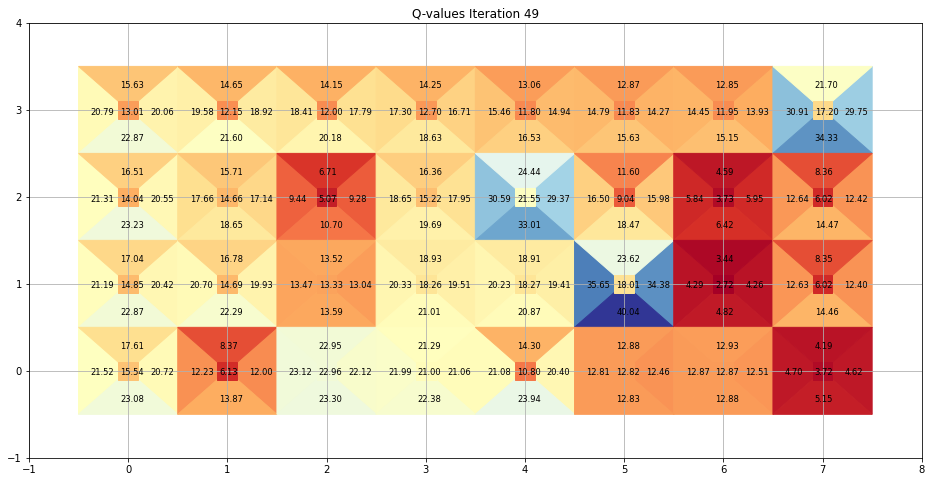

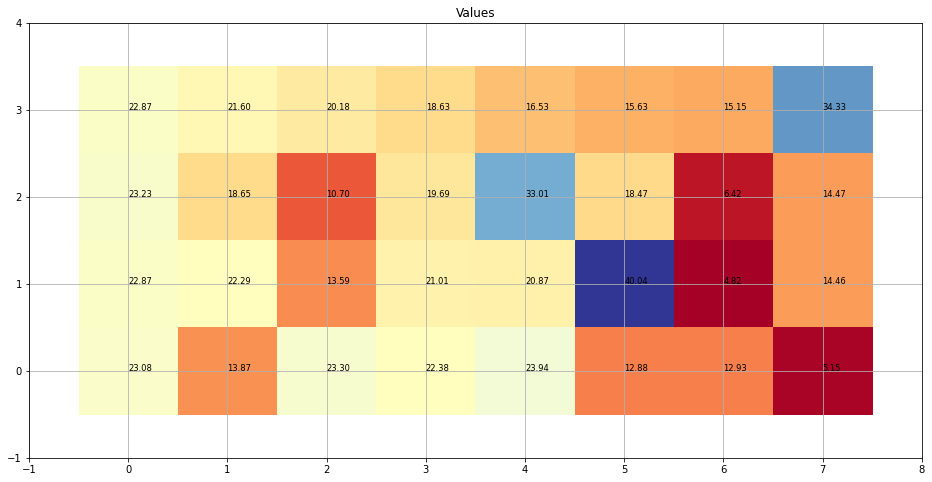

In [27]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])

# Run Q-iteration
q_values = fitted_q_iteration(env, network,
                              num_itrs=50, discount=0.95, 
                              render=True,
                              training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

# Correction for some problems of distributional shift
One of the main issues in offline RL is the problem of distributional shift:
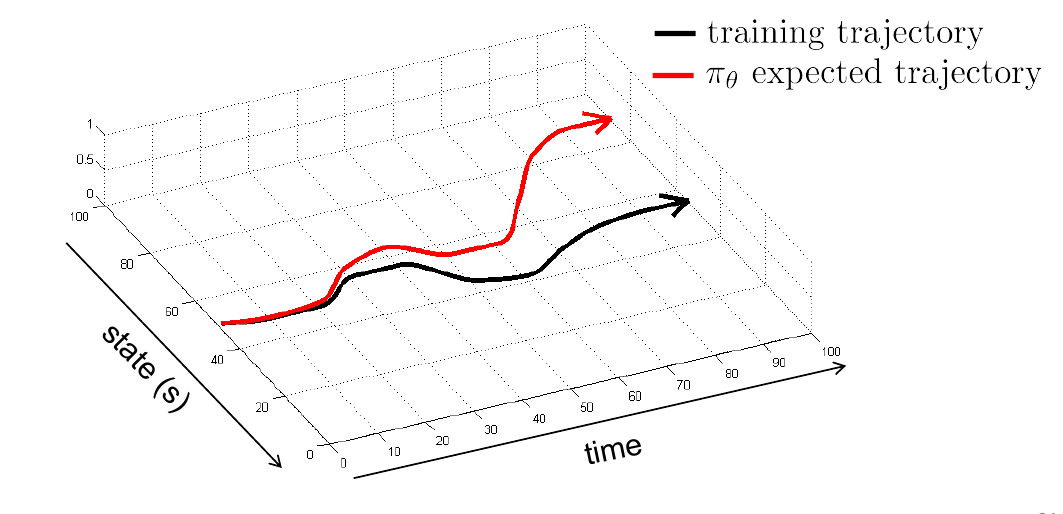


The general idea of conservative Q-learning is to prevent the learned policy (or Q-value) to get too far from the original policy (or Q-value), which collected the dataset. This can be achieved by adding some constraints on the policy or by modifying the training loss for q-value. One specific problem for Q-value is its overoptimism (exploding estimated returns). Here we will implement a version of fitted q-iteration with the correction for this specific problem.

**Exercise** fill the gaps in the code below:

In [16]:
def project_qvalues_cql_sampled(env, s, a, target_values, network, optimizer, cql_alpha=0.1, num_steps=50):
    # train with a sampled dataset
    target_qvalues = torch.tensor(target_values, dtype=torch.float32)
    s = torch.tensor(s, dtype=torch.int64)
    a = torch.tensor(a, dtype=torch.int64)
    pred_qvalues = network(s)

    #Calculate the soft maximum of pred_q_values
    #use torch.logsumexp and set the dimension to action dimension i.e. -1
    logsumexp_qvalues =  torch.logsumexp(pred_qvalues, dim=-1)
    
    pred_qvalues = pred_qvalues.gather(1, a.reshape(-1,1)).squeeze()

    #Defice cql loss ass logsumexp_qvalues - pred_qvalues
    cql_loss = logsumexp_qvalues - pred_qvalues
    
    loss = torch.mean((pred_qvalues - target_qvalues)**2)

    #Add cql_alpha * torch.mean(cql_loss) to loss
    loss += cql_alpha * torch.mean(cql_loss)

    network.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred_qvalues = network(torch.arange(env.num_states))
    return pred_qvalues.detach().numpy()
  
def conservative_q_iteration(env, 
                             network,
                             num_itrs=100, 
                             project_steps=50,
                             cql_alpha=0.1,
                             render=False,
                             training_dataset=None,
                             **kwargs):
  """
  Runs Conservative Q-iteration.
  
  Args:
    env: A GridEnv object.
    num_itrs (int): Number of FQI iterations to run.
    project_steps (int): Number of gradient steps used for projection.
    cql_alpha (float): Value of weight on the CQL coefficient.
    render (bool): If True, will plot q-values after each iteration.
    sampled (bool): Whether to use sampled datasets for training or not.
    training_dataset (list): list of (s, a, r, ns) pairs
  """
  dS = env.num_states
  dA = env.num_actions
  
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  
  q_values = np.zeros((dS, dA))
  for i in range(num_itrs):
    for j in range(project_steps):
      training_idx = np.random.choice(np.arange(len(training_dataset)), size=128)
      s, a, ns, r = get_tensors(training_dataset, training_idx)
      target_values = q_backup_sparse_sampled(env, q_values, s, a, ns, r, **kwargs)
      intermed_values = project_qvalues_cql_sampled(
          env, s, a, target_values, network, optimizer, 
          cql_alpha=cql_alpha,
      )
      if j == project_steps - 1:
        q_values = intermed_values
    if render:
      plot_sa_values(env, q_values, update=True, title='Q-values Iteration %d' %i)
  return q_values

In [17]:
# @title Input Parameters

dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  100#@param {type: "integer"}

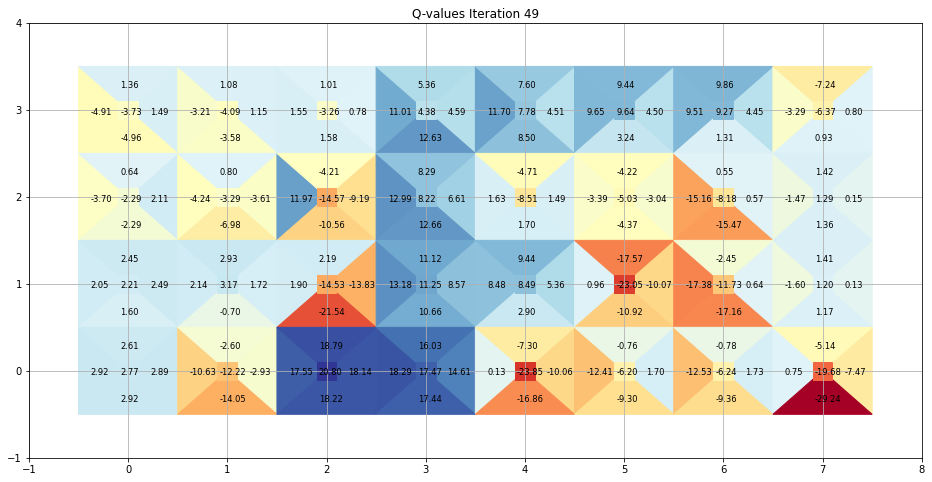

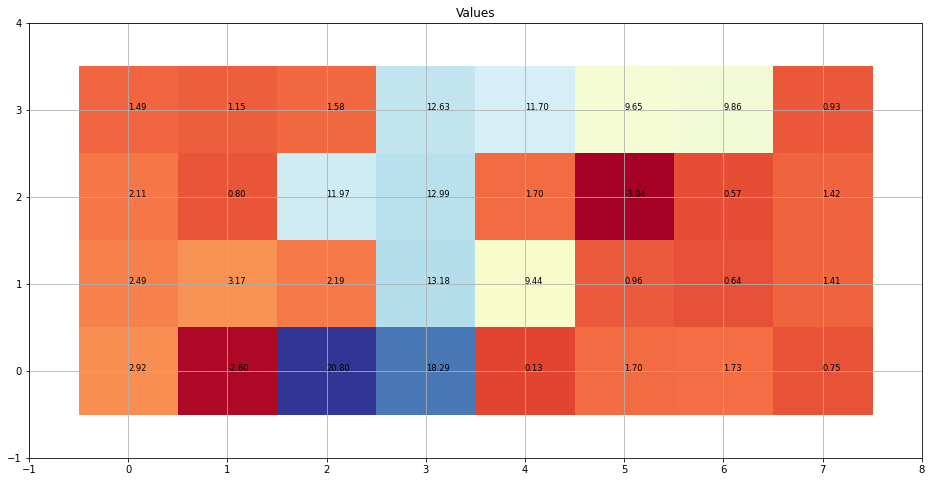

In [18]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 1.4 # @param {type:"slider", min:0.0, max:10.0, step:0.1}

# Run Q-iteration
q_values = conservative_q_iteration(env, network,
                                    num_itrs=50, discount=0.95, cql_alpha=cql_alpha_val, 
                                    render=True, training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

Let us check the error for CQL:

In [19]:
print('Total Error:', np.sum(np.abs(q_values - optimal_qvalues)))

Total Error: 1256.421193599584


**Exercise** Check how the total error depends on diffent values of cql_alpha_val (plot a simple graph for several values)

**Extra exercise** Try to construct a maze for wich CQL has great advantage over FQI.

In [28]:
# @title Input Parameters

dataset_composition = 'random+optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  500#@param {type: "integer"}

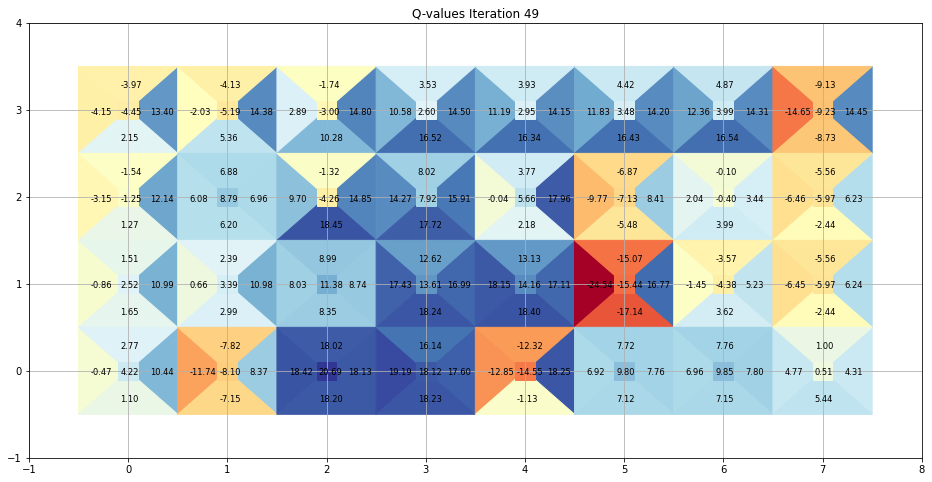

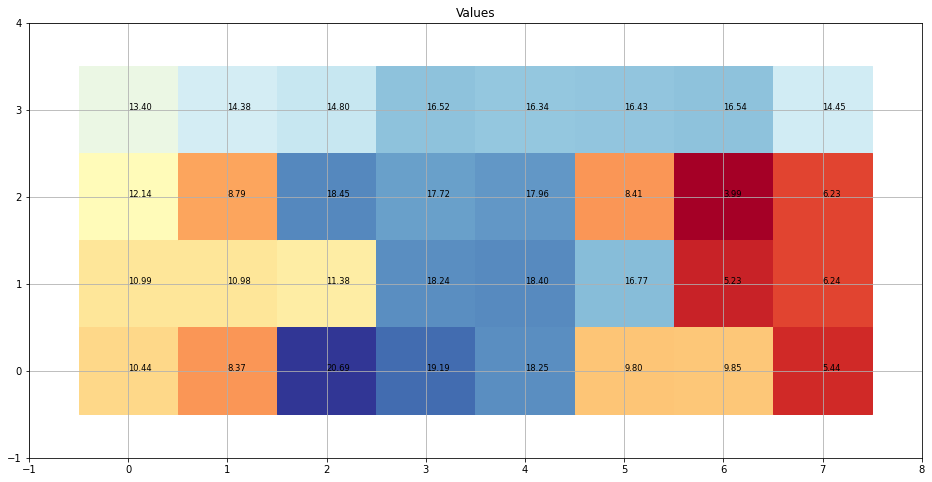

In [29]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 1.4 # @param {type:"slider", min:0.0, max:10.0, step:0.1}

# Run Q-iteration
q_values = conservative_q_iteration(env, network,
                                    num_itrs=50, discount=0.95, cql_alpha=cql_alpha_val, 
                                    render=True, training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

In [30]:
# @title Input Parameters

dataset_composition = 'optimal' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  100#@param {type: "integer"}

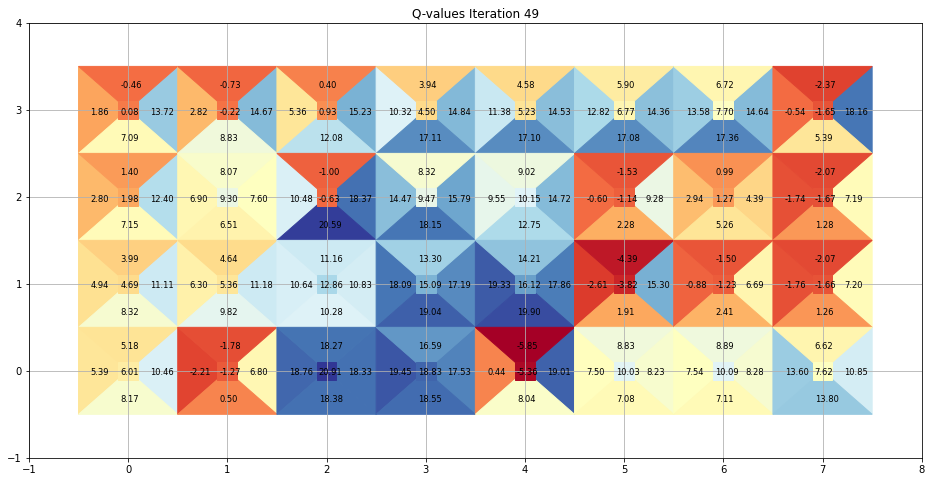

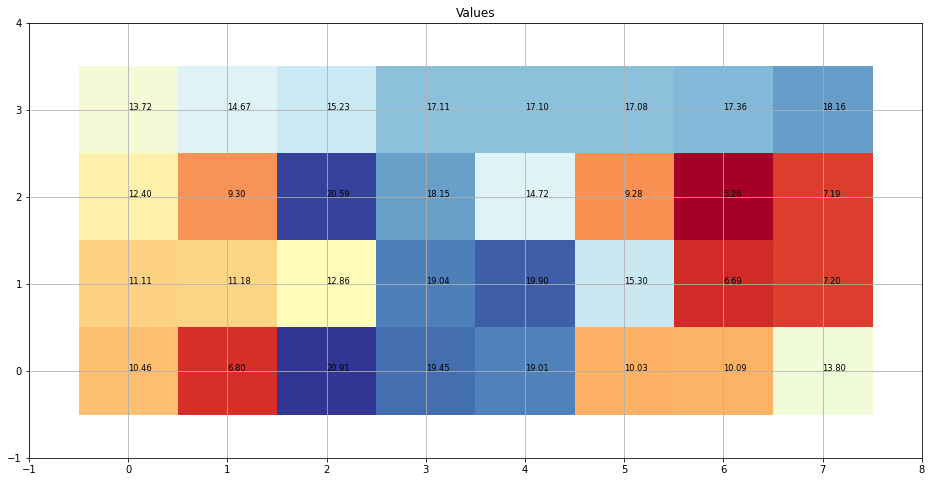

In [31]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 1.4 # @param {type:"slider", min:0.0, max:10.0, step:0.1}

# Run Q-iteration
q_values = conservative_q_iteration(env, network,
                                    num_itrs=50, discount=0.95, cql_alpha=cql_alpha_val, 
                                    render=True, training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')

In [32]:
# @title Input Parameters

dataset_composition = 'random' #@param ["optimal", "random", "random+optimal", "mixed"]
dataset_size =  100#@param {type: "integer"}

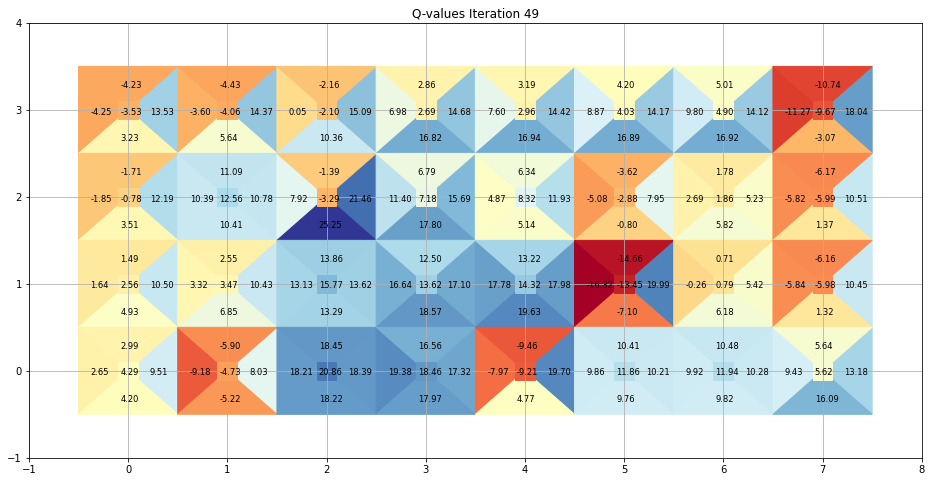

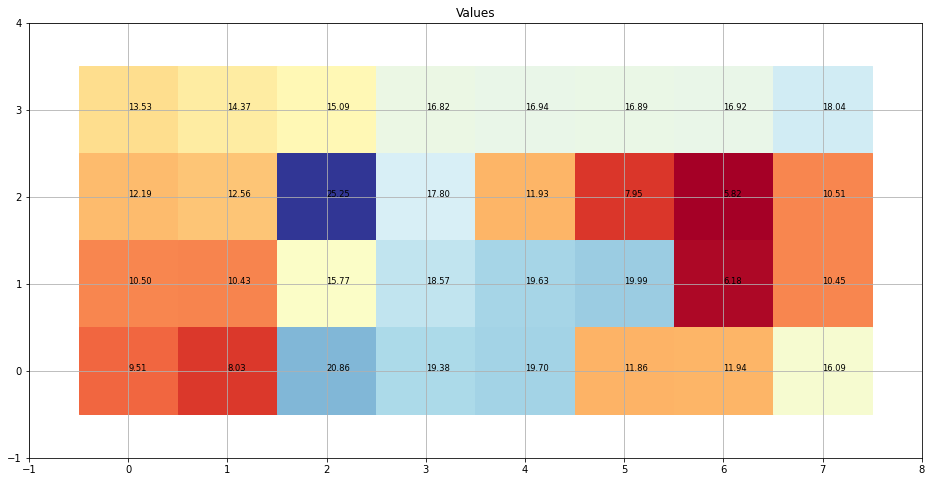

In [33]:
# Use a tabular or feedforward NN approximator
network = FCNetwork(env, layers=[20, 20])
#network = TabularNetwork(env)

cql_alpha_val = 1.4 # @param {type:"slider", min:0.0, max:10.0, step:0.1}

# Run Q-iteration
q_values = conservative_q_iteration(env, network,
                                    num_itrs=50, discount=0.95, cql_alpha=cql_alpha_val, 
                                    render=True, training_dataset=training_dataset)

# Compute and plot the value function
v_values = np.max(q_values, axis=1)
plot_s_values(env, v_values, title='Values')